In [1]:
import geopandas
import pandas
import pathlib
import numpy
import matplotlib
import shapely
import matplotlib.pyplot
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

# Plan
* Load in GeoFabrics estimated width, depth and water surface height - (using those used in GeoFabrics - i.e. same level of smoothing)
  * Calculate channel area - assume rectangular
* Load in measured cross sections
  * Transform to NZVD2016
  * Calculate the channel area - use the same water height as the GeoFabrics estimates
* Compare the results
  * Take the nearest GeoFabrics cross section to each measured cross section
  * Plot area's on the same plot

In [2]:
sampling_resolution = 10
sampled_section_spacing = 10

### Load in GeoFabrics Bathymetry estimates

In [3]:
cache_path = pathlib.Path(fr"C:\Users\pearsonra\Documents\data\Waikanae\caches\Wellington_2013\measured_river")
depths = geopandas.read_file(cache_path / "river_bathymetry.geojson")
estimated_sections = geopandas.read_file(cache_path / "final_cross_sections.geojson")
main_channel = geopandas.read_file(cache_path / "aligned_channel_100000000.geojson")

### Specify GeoFabric parameter
Both the column names used in calculations, and also select parameter file values

In [4]:
rupp_bed_elevation_name = 'bed_elevation_Rupp_and_Smart'
neal_bed_elevation_name = 'bed_elevation_Neal_et_al'

## Load in Measured cross sections
See raw cell below for converting to NZVD2016. This has already been done so load in the converted one directly

In [5]:
measured_sections = geopandas.read_file(r"C:/Users/pearsonra/Documents/data/river_bathemetry/sections/Waikanae/Waikanae_Cross_Sections_NIWA/2014_Survey_XS_NZVD2016.geojson")

### Simplify the measured points to min point/line strings

In [6]:
measured_centres = {'Section': [], 'geometry': []}
measured_lines = {'Section': [], 'geometry': [], 'min_elevation': []}
for section in measured_sections['Section'].unique():
    measured_section = measured_sections[measured_sections['Section'] == section]
    measured_centre = measured_section[measured_section['Level']==measured_section['Level'].min()].iloc[0]
    measured_centres['Section'].append(section)
    measured_centres['geometry'].append(measured_centre['geometry'])
    
    measured_lines['Section'].append(section)
    measured_lines['geometry'].append(shapely.geometry.LineString( [[measure_point.x, measure_point.y] for measure_point in measured_section.geometry.values] ))
    measured_lines['min_elevation'].append(measured_section['Level'].min())
measured_centres = geopandas.GeoDataFrame(measured_centres, crs=main_channel.crs)
measured_lines = geopandas.GeoDataFrame(measured_lines, crs=main_channel.crs)

## Identify the nearest depths/estimated sections

In [10]:
nearest_sections = []
nearest_depths = []
nearest_distances = []
i_max = len(depths) - 1 
for index, row in measured_lines.iterrows():
    distances = depths.distance(row.geometry)
    i_min = distances.argmin()
    direction = 1 # 1 if in front, -1 is behind
    if i_min == 0:
        if distances.iloc[1] > sampled_section_spacing: # Negative if next point is more than the sample spacing away
            direction = -1
    elif i_min == i_max:
        if distances.iloc[i_max - 1] < sampled_section_spacing:
            direction = -1
    elif distances.iloc[i_min - 1] < distances.iloc[i_min + 1]:
        direction = -1
    nearest_distances.append(distances.min() * direction)
    nearest_depths.append(depths.iloc[depths.distance(row.geometry).argmin()])
    nearest_sections.append(estimated_sections.iloc[depths.distance(row.geometry).argmin()])

# Construct dataframes
nearest_depths = geopandas.GeoDataFrame(nearest_depths, crs=main_channel.crs)
nearest_depths.insert(loc=0, column="Section", value=measured_lines["Section"])
nearest_sections = geopandas.GeoDataFrame(nearest_sections, crs=main_channel.crs)
nearest_sections.insert(loc=0, column="Section", value=measured_lines["Section"])
# This distance between the measured and sampled lines
measured_lines.insert(loc=0, column="Signed Distances", value=nearest_distances)

In [11]:
measured_lines.head(5)

,Signed Distances,Section,geometry,min_elevation
0,-10.581424,10.0,"LINESTRING (1769102.282 5473458.894, 1769102.3...",-1.84
1,-0.583508,20.0,"LINESTRING (1769184.341 5473401.670, 1769184.9...",-1.84
2,-4.032595,30.0,"LINESTRING (1769215.848 5473304.856, 1769216.7...",-2.23
3,2.747154,40.0,"LINESTRING (1769249.033 5473173.601, 1769254.9...",-1.18
4,-2.567583,50.0,"LINESTRING (1769349.601 5473063.784, 1769349.7...",-0.68


## Plot nearest sections

<AxesSubplot:>

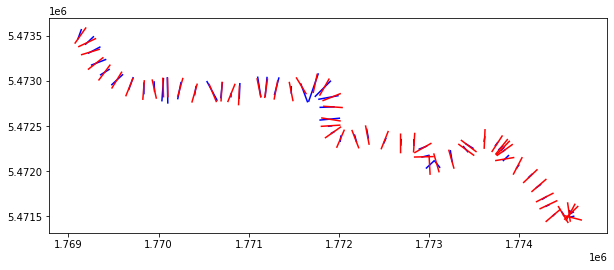

In [13]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(10, 15))

measured_lines.plot(ax=ax, color='b')
#nearest_depths.plot(ax=ax, color='m')
nearest_sections.plot(ax=ax, color='r')

## Update the index to be metres upstream

In [14]:
# Add the Upstream distance to the comprison sections
distance_upstream = nearest_depths.index * sampled_section_spacing
measured_lines.insert(loc=0, column='Distance Upstream', value=distance_upstream + measured_lines["Signed Distances"])
measured_lines = measured_lines.set_index(['Distance Upstream'])
nearest_depths.insert(loc=0, column='Distance Upstream', value=distance_upstream)
nearest_sections.insert(loc=0, column='Distance Upstream', value=distance_upstream)
nearest_depths = nearest_depths.set_index(['Distance Upstream'])
nearest_sections = nearest_sections.set_index(['Distance Upstream'])

In [15]:
# Add the Upstream distance to the comprison sections
distance_upstream = depths.index * sampled_section_spacing
depths.insert(loc=0, column='Distance Upstream', value=distance_upstream)
depths = depths.set_index(['Distance Upstream'])
estimated_sections.insert(loc=0, column='Distance Upstream', value=distance_upstream)
estimated_sections = estimated_sections.set_index(['Distance Upstream'])

<AxesSubplot:xlabel='Distance Upstream'>

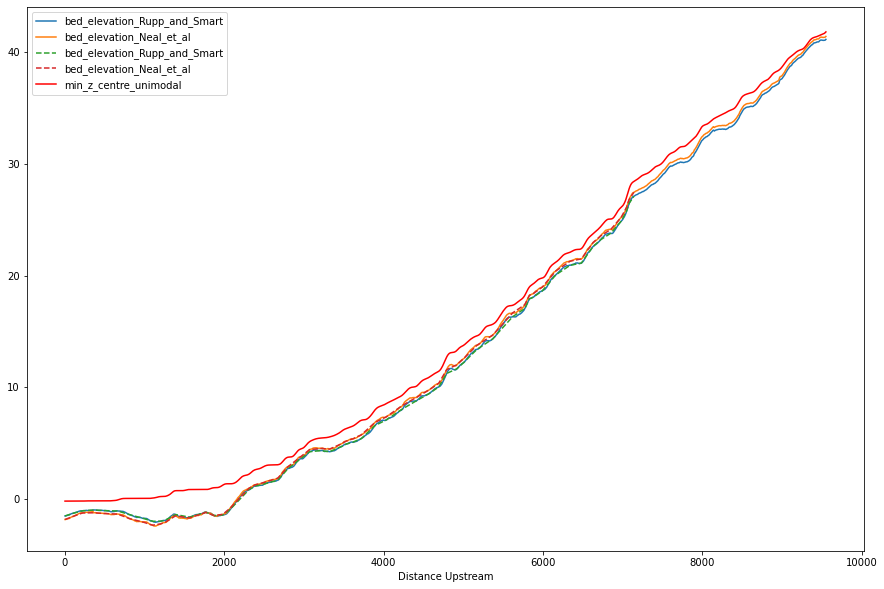

In [17]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(15, 10))

depths[[rupp_bed_elevation_name, neal_bed_elevation_name]].plot(ax=ax)
nearest_depths[[rupp_bed_elevation_name, neal_bed_elevation_name]].plot(ax=ax, linestyle="--")
estimated_sections[["min_z_centre_unimodal"]].plot(ax=ax, color='r')

## Plot lowest best elevation 
Specify distance upstream with time

<AxesSubplot:xlabel='Distance Upstream'>

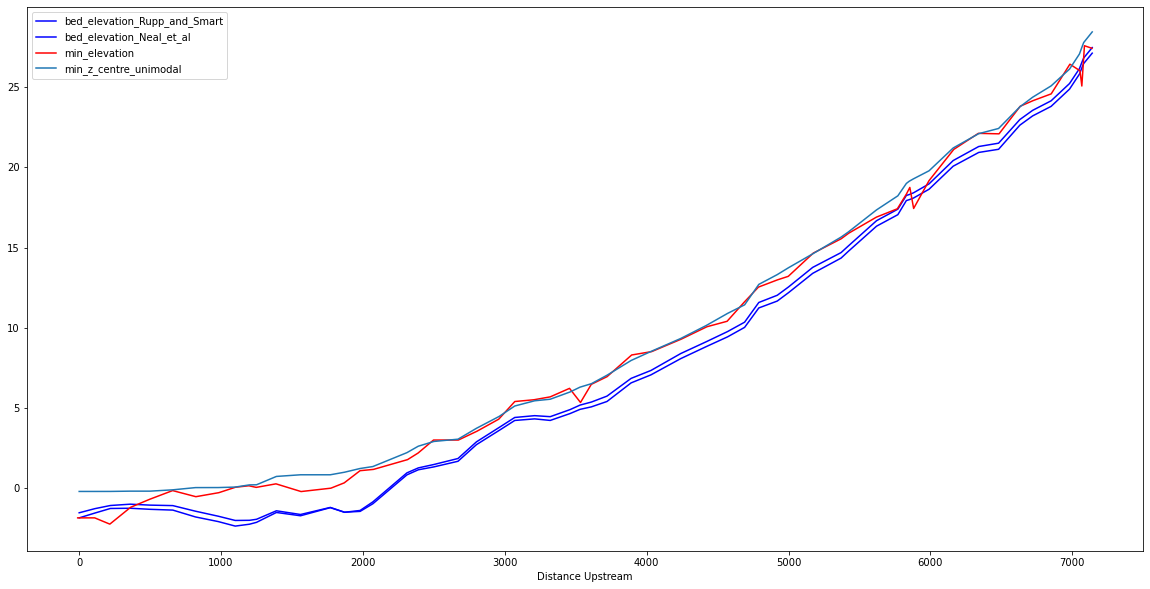

In [21]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(20, 10))

nearest_depths[[rupp_bed_elevation_name, neal_bed_elevation_name]].plot(ax=ax, color='b')
measured_lines[["min_elevation"]].plot(ax=ax, color='r')
nearest_sections[["min_z_centre_unimodal"]].plot(ax=ax)

# Note the awkwardness in deciding what to set as the water level reference for calculating the depth

<AxesSubplot:xlabel='Distance Upstream'>

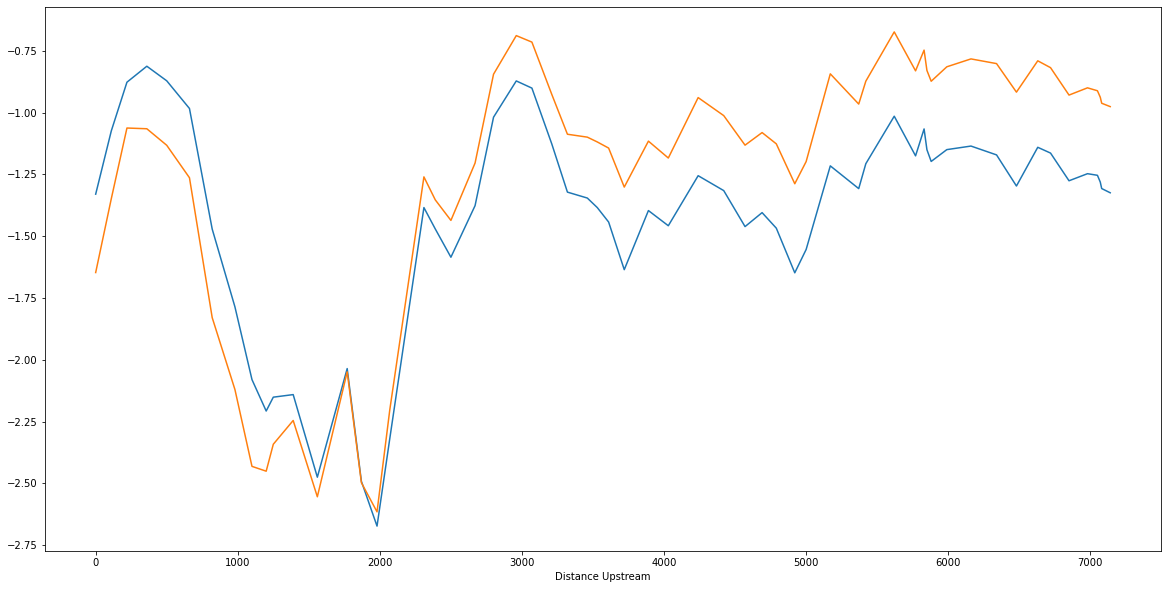

In [42]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(20, 10))

#(nearest_depths[[rupp_bed_elevation_name, neal_bed_elevation_name]]-nearest_sections[["min_z_centre_unimodal"]]).plot(ax=ax, color='b')
(nearest_depths[rupp_bed_elevation_name]-nearest_sections["min_z_centre_unimodal"]).plot(ax=ax)
(nearest_depths[neal_bed_elevation_name]-nearest_sections["min_z_centre_unimodal"]).plot(ax=ax)
#(measured_lines[["min_elevation"]]-nearest_sections["min_z_centre_unimodal"]).plot(ax=ax, color='r')
#nearest_sections[["min_z_centre_unimodal"]].plot(ax=ax)